# My Internship Notebook

## Imports

In [1]:
import os

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import time

from tensorflow import keras as tfk
from tensorflow.keras import regularizers
from tensorflow.keras import metrics
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import tensorflow_addons as tfa
import sklearn.model_selection 

import ad
from ad import utils

%load_ext autoreload
%autoreload 2

2023-06-29 11:26:49.183270: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/nfs/pic.es/user/l/lvalente/miniconda3/lib/python3.10/site-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


## Conversion from _file.txt_ to _file.npz_

### Data structure
**HEADER**:
1 x unsigned long (8 bytes) -> This is the number of rows

**ROWS** (EACH ROW HAS THIS STRUCTURE, resulting in 1029 columns... but with mixed datatypes):

1x unsigned long (8 bytes) -> How many floats, which right now turns out ot be 1028  
1028 x float (4 bytes each)

 **TODO**: try to normalize --> MinMaxScaler from sklearn.preprocessing

In [2]:
# Define the folder path and file names
folder_path = "./data"
file_names = ["fe_events.txt", "he_events.txt", "pr_events.txt"]
output_file = "data_events.npz"

if not os.path.exists(os.path.join(folder_path, output_file)):
    data = {}
    
    for file_name in file_names:
        file_path = os.path.join(folder_path, file_name)
        
        # Read the text file
        with open(file_path, 'r') as file:
            lines = file.readlines()

            # Read the rows
            rows = []
            for line in lines:
                row_data = np.fromstring(line, sep=' ', dtype=np.float32)
                rows.append(row_data)

            # Convert the rows list to a numpy array
            array_data = np.array(rows)

            # Store the array in the data dictionary
            data[file_name.split(".")[0]] = array_data
            print(f"Conversion completed successfully for file: {file_name}\n")

    # Save all the arrays as a single npz file
    np.savez(os.path.join(folder_path, output_file), **data)

    print(f"\nConversion completed successfully!\nFile saved in {output_file}")

else:
    data = np.load(os.path.join(folder_path, output_file))

    p  = data['pr_events']
    He = data['he_events']
    Fe = data['fe_events']

    print(f"The iron file has a shape of {Fe.shape}")
    print(f"The helium file has a shape of {He.shape}")
    print(f"The proton file has a shape of {p.shape}")

The iron file has a shape of (308630, 1028)
The helium file has a shape of (157637, 1028)
The proton file has a shape of (104172, 1028)


The M1 array is [1471.      383.25   1192.375  ... 1804.25   2022.5     465.6875]
The M2 array is [2044.75    146.6875 1489.625  ...  313.6562 2359.375   507.5625]


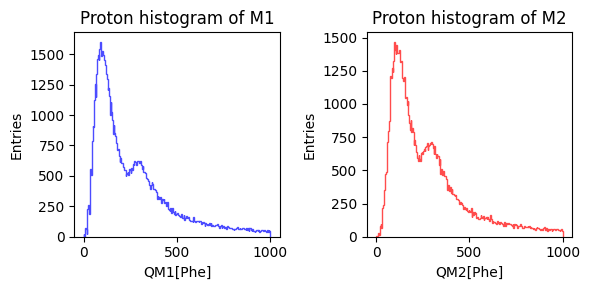

The M1 array is [139.0938   175.9375    69.218704 ... 253.99991   77.5625   724.5625  ]
The M2 array is [ 63.9688    63.8438   102.156204 ... 624.1875   341.7187   594.1875  ]


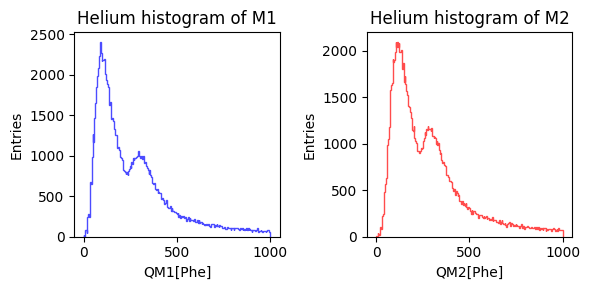

The M1 array is [176.62491 126.5937  181.0936  ... 414.9062  313.43738 386.5625 ]
The M2 array is [ 369.24988  219.4687   147.75    ...  609.125    360.7811  1024.75   ]


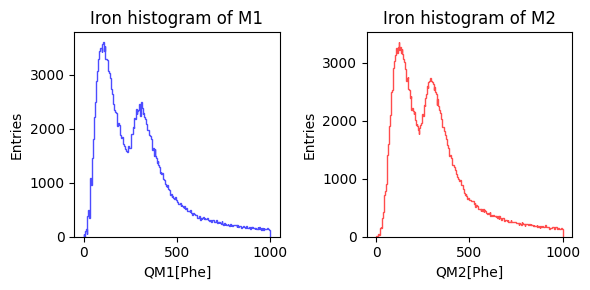

In [3]:
cut = None

M1, M2 = utils.plot_histograms(p , bins=250, range=(0,1000), cut=cut, title='Proton')
M1, M2 = utils.plot_histograms(He, bins=250, range=(0,1000), cut=cut, title='Helium')
M1, M2 = utils.plot_histograms(Fe, bins=250, range=(0,1000), cut=cut, title='Iron')

utils.free_mem()
del M1,M2

The final shape of Proton data is (43448, 1028)


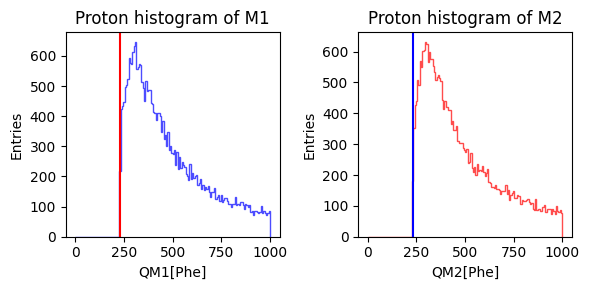

The final shape of Helium data is (68611, 1028)


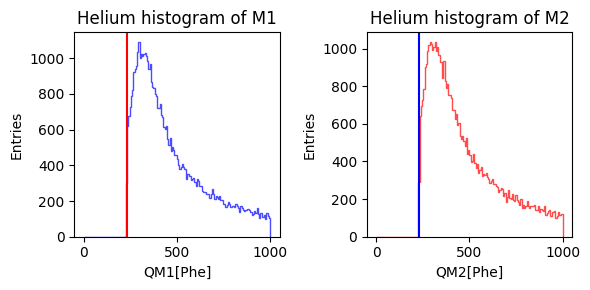

The final shape of Iron data is (155704, 1028)


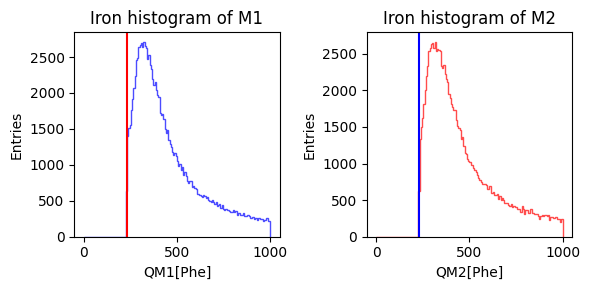

In [3]:
# Choose the cut of data here
cut = 230 #BEST: 230

fp  = utils.cut_data_by_threshold(p , cut=cut, range=(0,1000), title='Proton')
fHe = utils.cut_data_by_threshold(He, cut=cut, range=(0,1000), title='Helium')
fFe = utils.cut_data_by_threshold(Fe, cut=cut, range=(0,1000), title='Iron')

In [4]:
#fHe = fHe[:len(fp)]
#fFe = fFe[:len(fp)]

print(fp.shape, fHe.shape, fFe.shape,)

X = np.concatenate((fp, fHe, fFe), axis=0)
print(X.shape)

(43448, 1028) (68611, 1028) (155704, 1028)
(267763, 1028)


## Creation of labels 

In [5]:
yFe = np.zeros((len(fFe), ), dtype = int) 
yFe[:] = 2  
yHe = np.ones((len(fHe), ), dtype = int) 
yp = np.zeros((len(fp), ), dtype = int) 

print(f"label for protons: {yp[:]}" )
print(f"label for helium:  {yHe[:]}")
print(f"label for Iron:    {yFe[:]}")

y = np.concatenate((yp, yHe, yFe), axis=0)
y= tfk.utils.to_categorical(y)

print(f"\n The shape of the concatenated array: {y.shape}")
utils.free_mem()
del yFe, yHe, yp, Fe, He, p, fFe, fHe, fp

label for protons: [0 0 0 ... 0 0 0]
label for helium:  [1 1 1 ... 1 1 1]
label for Iron:    [2 2 2 ... 2 2 2]

 The shape of the concatenated array: (267763, 3)


In [6]:
x_train, x_valid, y_train, y_valid = sklearn.model_selection.train_test_split(X, y, train_size = 0.75, shuffle = True) #Best: train = 75%

utils.free_mem()
#del X, y

print(y_train[:4])
print(x_train.shape, x_valid.shape, y_train.shape, y_valid.shape)

[[1. 0. 0.]
 [0. 0. 1.]
 [0. 1. 0.]
 [0. 0. 1.]]
(200822, 1028) (66941, 1028) (200822, 3) (66941, 3)


## FeedForward Neural Network Model

In [22]:
from ad.models.FFNN import FFNN

model = FFNN(
                name = 'FFNetwork',
                num_classes = 3, # Fe, He, p

                 
                network = dict( layer_sizes = [ 128, 64 ], # BEST: [ 128,64 ]
                                # activation = 'relu',
                                kernel_initializer= 'he_uniform', #BEST : 'he_uniform'
                                kernel_regularizer=regularizers.L2(l2 = 1e-3), #BEST : regularizers.l2(0.001)
                                BN = True, #BEST: TRUE
                                PRelu = True, #BEST: TRUE
                                dropout_rate = None, #BEST: None
                                input_shape = ( 1028, )
                                )
)
model.summary()

Model: "Classifier"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 1028)]            0         
                                                                 
 d0 (Dense)                  (None, 128)               131712    
                                                                 
 bn0 (BatchNormalization)    (None, 128)               512       
                                                                 
 prelu0 (PReLU)              (None, 128)               128       
                                                                 
 d1 (Dense)                  (None, 64)                8256      
                                                                 
 bn1 (BatchNormalization)    (None, 64)                256       
                                                                 
 prelu1 (PReLU)              (None, 64)                6

In [23]:
# Compile the model with the specified metrics
model.network.compile(optimizer='adam', # BEST: 'adam'
                      loss='categorical_crossentropy',
                      metrics=['accuracy', 
                               metrics.AUC(name='AUC'),
                               metrics.Precision(name='prec'), 
                               metrics.Recall(name='rec'),
                               tfa.metrics.F1Score(num_classes=3, average='weighted', name='f1'),
                                ]
                               )

In [24]:
train = True

if train:
    # Define your callbacks
    early_stop = tfk.callbacks.EarlyStopping(monitor='val_loss', verbose=True, patience=4, #BEST: patiente = 4
                                              restore_best_weights=True)
    reduceLR = tfk.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=4, verbose=1)
    model_checkpoint = ModelCheckpoint('./weights/FFNN/model_weights.h5', 
                                       save_best_only=True,
                                       monitor='val_loss',
                                       mode='max',
                                       verbose=1)

    # Train the model
    start_loop = time.time()
    model.train(x_train, y_train, 
                x_valid, y_valid, 
                epochs=40, 
                batch_size=256, 
                callbacks=[early_stop, model_checkpoint, reduceLR])
    print("\nTotal time taken: %.2f min \n" % ((time.time() - start_loop)/60.) )
    # Save the model weights
    model.network.save_weights('./weights/FFNN.h5')
    model.network.load_weights('./weights/FFNN/model_weights.h5')
else: 
    # Load the saved model weights
    model.network.load_weights('./weights/FFNN/model_weights.h5')

# Evaluate the model on the test set
test_loss, *test_metrics = model.evaluate(x_valid, y_valid)
print('Test loss:', test_loss)
print('Test metrics:', test_metrics)


Epoch 1/40
785/785 [==============================] - ETA: 0s - loss: 0.8599 - accuracy: 0.6094 - AUC: 0.7895 - prec: 0.7041 - rec: 0.4706 - f1: 0.5540
Epoch 1: val_loss improved from -inf to 0.82566, saving model to ./weights/FFNN/model_weights.h5
785/785 [==============================] - 24s 27ms/step - loss: 0.8599 - accuracy: 0.6094 - AUC: 0.7895 - prec: 0.7041 - rec: 0.4706 - f1: 0.5540 - val_loss: 0.8257 - val_accuracy: 0.6285 - val_AUC: 0.8092 - val_prec: 0.7044 - val_rec: 0.5250 - val_f1: 0.5599 - lr: 0.0010
Epoch 2/40
784/785 [============================>.] - ETA: 0s - loss: 0.8074 - accuracy: 0.6373 - AUC: 0.8173 - prec: 0.7271 - rec: 0.5074 - f1: 0.5941
Epoch 2: val_loss did not improve from 0.82566
785/785 [==============================] - 22s 27ms/step - loss: 0.8074 - accuracy: 0.6373 - AUC: 0.8174 - prec: 0.7272 - rec: 0.5074 - f1: 0.5941 - val_loss: 0.8116 - val_accuracy: 0.6332 - val_AUC: 0.8156 - val_prec: 0.7255 - val_rec: 0.5054 - val_f1: 0.5963 - lr: 0.0010
Epoc

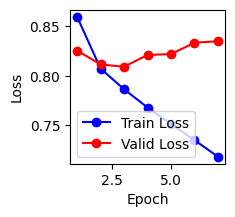

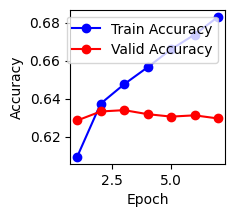

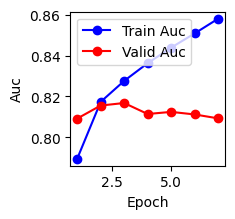

Minimum weight value: -1.362614631652832
Maximum weight value: 1.3263685703277588


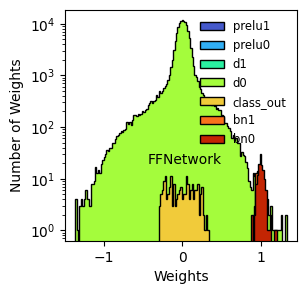

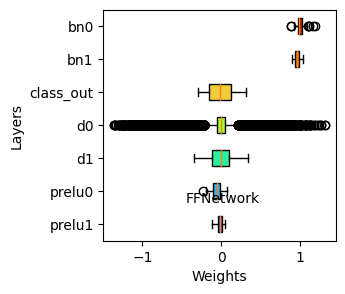

In [27]:
if train:
    utils.plot_metrics(model,metric='loss')
    utils.plot_metrics(model,metric='accuracy')
    utils.plot_metrics(model,metric='AUC')
    model.network.load_weights('./weights/FFNN/model_weights.h5')

utils.doWeights(model, log=True, figsize=(3,3))
utils.WhiskerWeights(model, figsize=(3,3))

### Model Evaluation

2092/2092 [==============================] - 11s 5ms/step
 
 Prediction: 
 [[0.22851217 0.45596674 0.3155211 ]
 [0.16807956 0.3597857  0.47213477]
 [0.15407015 0.2947668  0.551163  ]
 ...
 [0.13934861 0.25328085 0.6073705 ]
 [0.09455623 0.22821362 0.67723006]
 [0.09140068 0.21200815 0.6965912 ]]

 True labels: 
 [[0. 0. 1.]
 [0. 1. 0.]
 [0. 0. 1.]
 ...
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]]

 Indices of uncorrectly predicted samples:
[0, 1, 4, 6, 8, 12, 15, 16, 19, 21, 25, 30, 32, 33, 35, 37, 39, 40, 53, 54, 55, 56, 63, 64, 65, 69, 71, 73, 76, 80, 81, 84, 86, 87, 93, 97, 101, 103, 107, 110, 118, 120, 124, 125, 126, 128, 129, 130, 131, 133, 136, 138, 148, 152, 153, 155, 157, 162, 164, 165, 167, 168, 171, 173, 174, 176, 178, 179, 182, 186, 187, 192, 193, 201, 202, 205, 218, 221, 231, 234, 236, 237, 246, 251, 253, 254, 255, 258, 260, 261, 262, 266, 270, 272, 274, 278, 280, 292, 294, 297, 298, 299, 301, 304, 311, 313, 314, 317, 318, 321, 322, 325, 326, 328, 329, 332, 333, 335, 342, 345, 347,

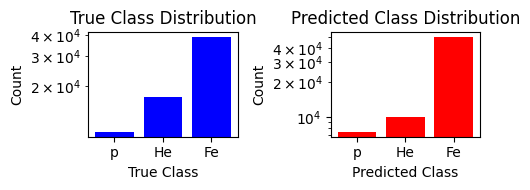

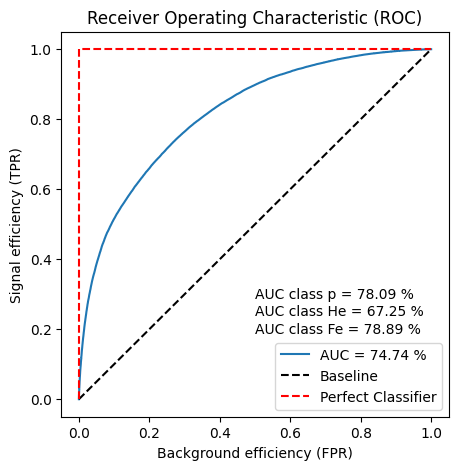

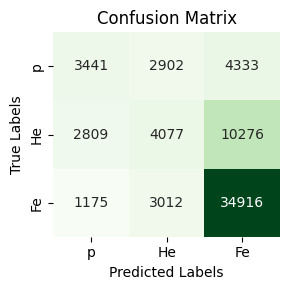

In [28]:
predictions = model.predict(x_valid)
correct_predictions = []

for i in range(len(predictions)):
    predicted_class = np.argmax(predictions[i])
    true_class = np.argmax(y_valid[i])

    if predicted_class != true_class:
        correct_predictions.append(i)

print(f' \n Prediction: \n {predictions}')
print('\n True labels: \n', y_valid)
print("\n Indices of uncorrectly predicted samples:")
print(correct_predictions)

predicted_labels = np.argmax(predictions, axis=1)
true_labels = np.argmax(y_valid, axis=1)

print("Predictions:", predicted_labels)
print("True Labels:", true_labels)
accuracy = np.mean(predicted_labels == true_labels) * 100
print("\n Accuracy:", accuracy, "%")

utils.visualize_class_distribution( y_valid, predictions, figsize=(5, 2))
utils.plot_auc( y_valid, predictions) # BEST: auc =  73 %
utils.plot_confusion_matrix( y_valid, predictions)

2144/2144 [==============================] - 11s 5ms/step


TypeError: unhashable type: 'slice'

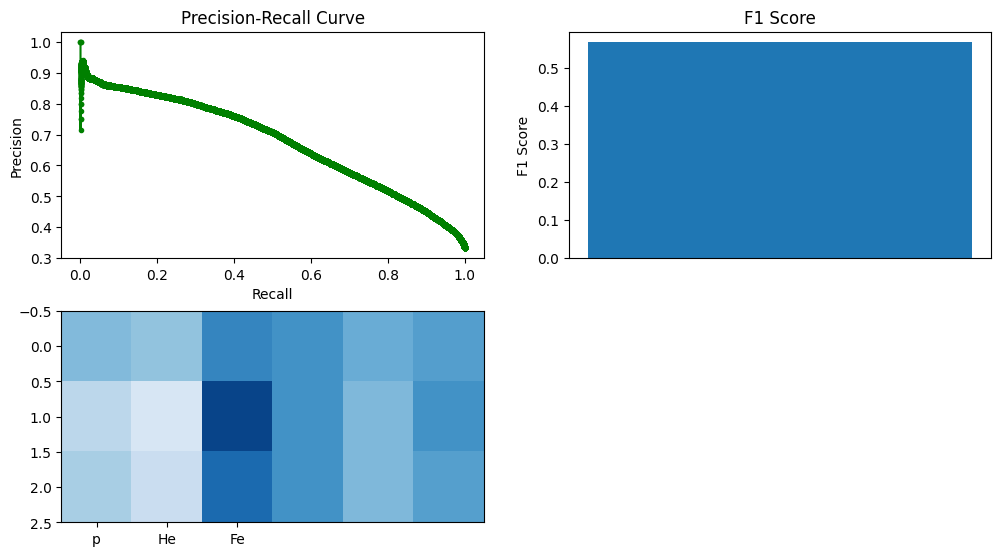

In [13]:
utils.plot_evaluation_plots(model, x_valid, y_valid)

In [ ]:
break

SyntaxError: 'break' outside loop (668683560.py, line 1)

## Ensemble Learning FFNN

In [8]:
from ad.models.FFNN import EnsembleFFNN

ensemble_model = EnsembleFFNN(
                    name='EnsembleFFNetwork',
                    num_classes = 3,  # Fe, He, p
                    num_models = 8,
                    network=dict(
                                layer_sizes=[128, 64],
                                kernel_initializer='he_uniform',
                                #kernel_regularizer=regularizers.l2(0.001),
                                BN=True,
                                PRelu=True,
                                dropout_rate=None,
                                input_shape=(1028,)
                                )
                            )
ensemble_model.summary()


2023-06-28 15:08:51.469505: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


Summary of Model 1:
Model: "Classifier"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 1028)]            0         
                                                                 
 d0 (Dense)                  (None, 128)               131712    
                                                                 
 bn0 (BatchNormalization)    (None, 128)               512       
                                                                 
 prelu0 (PReLU)              (None, 128)               128       
                                                                 
 d1 (Dense)                  (None, 64)                8256      
                                                                 
 bn1 (BatchNormalization)    (None, 64)                256       
                                                                 
 prelu1 (PReLU)              (None, 

In [10]:
train = True

if train:
    # Define your callbacks
    early_stop = tfk.callbacks.EarlyStopping(monitor='val_loss', verbose=True, patience=4,
                                              restore_best_weights=True)
    reduceLR = tfk.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=4, verbose=1)
    model_checkpoint = ModelCheckpoint('./weights/MultiFFNN/model_weights.h5', 
                                       save_best_only=True,
                                       monitor='val_loss',
                                       mode='max',
                                       verbose=1)

    # Train the model
    start_loop = time.time()
    ensemble_model.train(X, y,  
                epochs=40, 
                batch_size=256, 
                callbacks=[early_stop, model_checkpoint, reduceLR])
    print("\nTotal time taken: %.2f min \n" % ((time.time() - start_loop)/60.) )
    # Save the model weights
    #model.save_weights('./weights/FFNN.h5')
    #model.load_weights('./weights/FFNN/model_weights.h5')
#else: 
    # Load the saved model weights
    #model.load_weights('./weights/FFNN/model_weights.h5')

# Evaluate the model on the test set
test_loss, *test_metrics = model.evaluate(x_valid, y_valid)
print('Test loss:', test_loss)
print('Test metrics:', test_metrics)



Training Model 1
Epoch 1/40
785/785 [==============================] - ETA: 0s - loss: 0.8626 - accuracy: 0.6077 - AUC: 0.7884 - prec: 0.7047 - rec: 0.4690 - f1: 0.5519

KeyboardInterrupt: 

In [ ]:
if train:
    for i, model in enumerate(ensemble_model.models):
        utils.plot_metrics(model,metric='loss')
        utils.plot_metrics(model,metric='accuracy')
        utils.plot_metrics(model,metric='AUC')
        model.network.load_weights('./weights/FFNN/model_weights.h5')

utils.doWeights(model, log=True, figsize=(3,3))
utils.WhiskerWeights(model, figsize=(3,3))

AttributeError: 'tuple' object has no attribute 'history'

### Model Evaluation

2092/2092 [==============================] - 10s 5ms/step
 
 Prediction: 
 [[0.41553292 0.35725784 0.22720921]
 [0.5317519  0.35402477 0.11422334]
 [0.07833929 0.1962425  0.7254182 ]
 ...
 [0.07656807 0.17412582 0.7493061 ]
 [0.07621143 0.27862197 0.6451666 ]
 [0.02082389 0.08324145 0.8959347 ]]

 True labels: 
 [[0. 1. 0.]
 [1. 0. 0.]
 [0. 0. 1.]
 ...
 [0. 0. 1.]
 [0. 1. 0.]
 [0. 0. 1.]]

 Indices of uncorrectly predicted samples: 
[0, 14, 20, 24, 25, 28, 30, 31, 34, 36, 39, 40, 44, 50, 60, 61, 62, 63, 70, 71, 72, 74, 76, 85, 86, 87, 89, 92, 93, 94, 98, 101, 103, 105, 107, 109, 114, 116, 123, 124, 139, 144, 148, 149, 152, 155, 156, 158, 159, 162, 167, 169, 170, 172, 173, 174, 177, 180, 181, 183, 184, 186, 187, 188, 189, 192, 196, 197, 198, 200, 201, 205, 207, 208, 211, 218, 219, 220, 230, 231, 236, 237, 239, 243, 245, 251, 255, 258, 265, 269, 270, 272, 274, 279, 282, 288, 289, 290, 292, 294, 296, 297, 298, 299, 300, 303, 310, 315, 316, 317, 322, 323, 324, 325, 328, 330, 331, 332, 334,

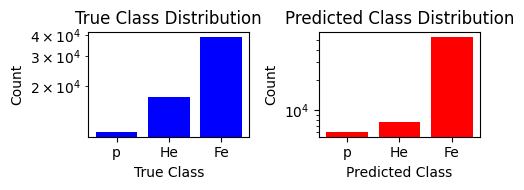

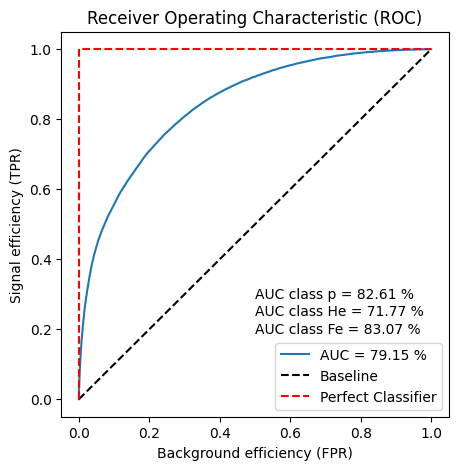

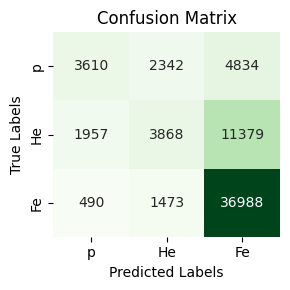

In [13]:
predictions = ensemble_model.predict(x_valid)
uncorrect_predictions = []

for i in range(len(predictions)):
    predicted_class = np.argmax(predictions[i])
    true_class = np.argmax(y_valid[i])

    if predicted_class != true_class:
        uncorrect_predictions.append(i)

print(f' \n Prediction: \n {predictions}')
print('\n True labels: \n', y_valid)
print(f"\n Indices of uncorrectly predicted samples: \n{uncorrect_predictions}")
print(f"The percentage of uncorrect prediction: {(len(uncorrect_predictions)/x_valid.shape[0])*100:.2f} % \n\n")

predicted_labels = np.argmax(predictions, axis=1)
true_labels = np.argmax(y_valid, axis=1)

print("Predictions:", predicted_labels)
print("True Labels:", true_labels)
accuracy = np.mean(predicted_labels == true_labels) * 100
print("\n Model accuracy:", accuracy, "%")

utils.visualize_class_distribution( y_valid, predictions, figsize=(5, 2))
utils.plot_auc( y_valid, predictions) # BEST: auc =  79.15 %
utils.plot_confusion_matrix( y_valid, predictions)

2092/2092 [==============================] - 11s 5ms/step


TypeError: unhashable type: 'slice'

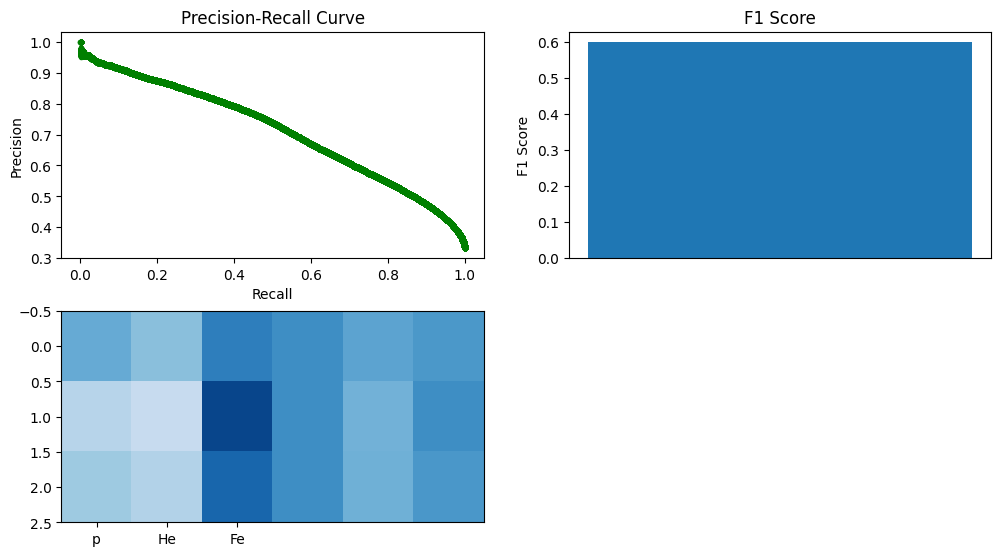

In [ ]:
utils.plot_evaluation_plots(model, x_valid, y_valid)

## Ensemble FFN2

In [7]:
from ad.models.EnsembleFNN import EnsembleFFNN

num_models = 5
num_classes = 3
epochs = 10

# Define hyperparameter values for each model
#learning_rates = [ 1e-3, 1e-2, 1e-1, 1e-4, 1e-5 ] #0.001, 0.01, 0.1, 0.0001, 1e-5
#print(f"the learning rates are: {learning_rates}")

batch_sizes =    [128,  256,  512,   64,   32 ] #  128,  256, 512,    64,    32
print(f"the batch sizes are: {batch_sizes}")

#kernel_initializers = ['he_uniform', 'glorot_uniform', 'random_normal', 'lecun_normal', 'he_normal']
#print(f"the different kernel initializers are: {kernel_initializers}")


# Create an instance of EnsembleFFNN with different models
ensemble_model = EnsembleFFNN(
                                num_models=num_models, 
                                num_classes=num_classes,
                                #learning_rates=learning_rates, 
                                batch_sizes=batch_sizes, 
                                #kernel_initializers=kernel_initializers
                             )
ensemble_model.summary()

the batch sizes are: [128, 256, 512, 64, 32]


2023-06-29 11:27:49.115565: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


Summary of Model 1:
Model: "Classifier"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 1028)]            0         
                                                                 
 d0 (Dense)                  (None, 128)               131712    
                                                                 
 bn0 (BatchNormalization)    (None, 128)               512       
                                                                 
 prelu0 (PReLU)              (None, 128)               128       
                                                                 
 d1 (Dense)                  (None, 64)                8256      
                                                                 
 bn1 (BatchNormalization)    (None, 64)                256       
                                                                 
 prelu1 (PReLU)              (None, 

In [9]:
# Train the models
ensemble_model.train(X, y, epochs=epochs)

# Evaluate the models
#losses, accuracies = ensemble_model.evaluate(x_valid, y_valid)

# Print the results
#for i in range(num_models):
    #print(f"Model {i+1} - Learning Rate: {learning_rates[i]}, Batch Size: {batch_sizes[i]}")
    #print(f"Loss: {losses[i]}, Accuracy: {accuracies[i]}")
 #   print("\n")


Training Model 1
Epoch 1/10
1569/1569 [==============================] - 42s 25ms/step - loss: 0.8603 - accuracy: 0.6091 - AUC: 0.7895 - prec: 0.7041 - rec: 0.4718 - f1: 0.5565 - val_loss: 0.8306 - val_accuracy: 0.6249 - val_AUC: 0.8060 - val_prec: 0.7093 - val_rec: 0.5067 - val_f1: 0.5645
Epoch 2/10
1569/1569 [==============================] - 41s 26ms/step - loss: 0.8074 - accuracy: 0.6374 - AUC: 0.8174 - prec: 0.7263 - rec: 0.5086 - f1: 0.5949 - val_loss: 0.8192 - val_accuracy: 0.6325 - val_AUC: 0.8122 - val_prec: 0.7128 - val_rec: 0.5177 - val_f1: 0.5813
Epoch 3/10
1569/1569 [==============================] - 40s 25ms/step - loss: 0.7862 - accuracy: 0.6480 - AUC: 0.8278 - prec: 0.7325 - rec: 0.5252 - f1: 0.6108 - val_loss: 0.8313 - val_accuracy: 0.6299 - val_AUC: 0.8100 - val_prec: 0.6964 - val_rec: 0.5338 - val_f1: 0.5704
Epoch 4/10
1569/1569 [==============================] - 38s 24ms/step - loss: 0.7687 - accuracy: 0.6575 - AUC: 0.8359 - prec: 0.7386 - rec: 0.5385 - f1: 0.6245 

### Reload model

In [8]:
utils.free_mem()

862

In [9]:
# Reload the models
ensemble_model = utils.reload_models(ensemble_model.num_models, "./weights/MultiFFNN")

In [10]:
def get_predictions(reloaded_models, X):
    individual_predictions = []
    for model in reloaded_models:
        individual_predictions.append(model.predict(X))
    
    average_prediction = np.mean(individual_predictions, axis=0)
    
    return average_prediction

predictions = get_predictions(ensemble_model, x_valid)

2092/2092 [==============================] - 7s 3ms/step


### Model Evaluation

 
 Prediction: 
 [[0.5064203  0.4557007  0.03787907]
 [0.10076816 0.18123914 0.7179927 ]
 [0.08478343 0.17551899 0.7396976 ]
 ...
 [0.01527437 0.06150514 0.92322046]
 [0.06222041 0.18599574 0.75178385]
 [0.09328382 0.19681773 0.7098984 ]]

 True labels: 
 [[0. 1. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 ...
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]]

 Indices of uncorrectly predicted samples: 
[0, 10, 13, 15, 16, 17, 18, 19, 33, 35, 38, 41, 45, 47, 48, 52, 54, 59, 64, 70, 86, 89, 96, 97, 101, 103, 104, 107, 108, 113, 114, 116, 119, 122, 125, 126, 128, 130, 134, 144, 153, 154, 155, 156, 163, 166, 169, 170, 175, 176, 182, 183, 185, 189, 190, 193, 196, 200, 202, 203, 207, 212, 223, 224, 229, 231, 232, 235, 237, 240, 245, 248, 249, 256, 261, 267, 268, 271, 274, 278, 279, 280, 291, 292, 295, 311, 312, 316, 321, 325, 328, 332, 344, 346, 347, 349, 353, 354, 358, 362, 363, 364, 366, 368, 371, 373, 374, 385, 388, 393, 400, 401, 402, 404, 408, 414, 416, 420, 422, 429, 431, 433, 435, 437, 438, 439, 441, 445, 447, 

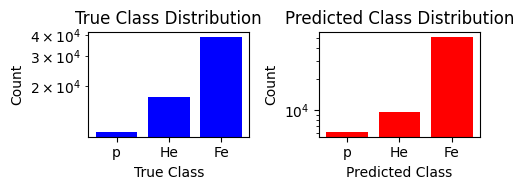

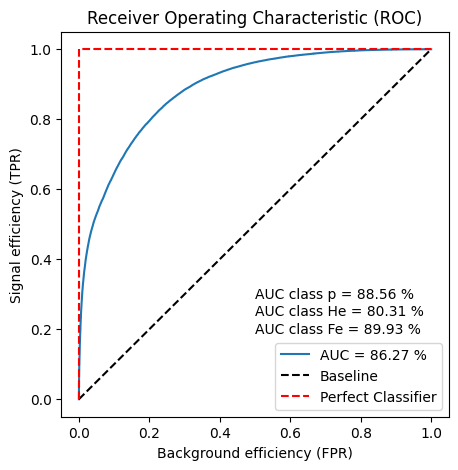

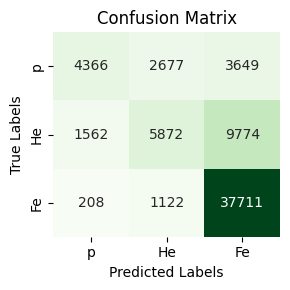

In [12]:
#predictions = ensemble_model.predict(x_valid)
uncorrect_predictions = []

for i in range(len(predictions)):
    predicted_class = np.argmax(predictions[i])
    true_class = np.argmax(y_valid[i])

    if predicted_class != true_class:
        uncorrect_predictions.append(i)

print(f' \n Prediction: \n {predictions}')
print('\n True labels: \n', y_valid)
print(f"\n Indices of uncorrectly predicted samples: \n{uncorrect_predictions}")
#print(f"The percentage of uncorrect prediction: {(len(uncorrect_predictions)/x_valid.shape[0])*100:.2f} % \n\n")

predicted_labels = np.argmax(predictions, axis=1)
true_labels = np.argmax(y_valid, axis=1)

print("Predictions:", predicted_labels)
print("True Labels:", true_labels)
accuracy = np.mean(predicted_labels == true_labels) * 100
print("\n Model accuracy:", accuracy, "%")

utils.visualize_class_distribution( y_valid, predictions, figsize=(5, 2))
utils.plot_auc( y_valid, predictions) # BEST: auc =  86 %
utils.plot_confusion_matrix( y_valid, predictions)

In [22]:
print(predictions.shape)

(66941, 3)


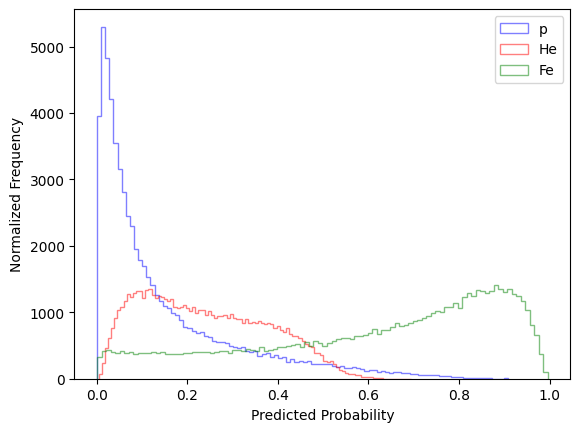

In [13]:
# Split predictions into three separate arrays for each class
p_predictions = predictions[:, 0]
he_predictions = predictions[:, 1]
fe_predictions = predictions[:, 2]

# Create histogram for each class
plt.hist(p_predictions, bins=100, alpha=0.5, label='p', color='blue', histtype='step')
plt.hist(he_predictions, bins=100, alpha=0.5, label='He', color='red', histtype='step')
plt.hist(fe_predictions, bins=100, alpha=0.5, label='Fe', color='green', histtype='step')

# Set plot labels and legend
plt.xlabel('Predicted Probability')
plt.ylabel('Normalized Frequency')
plt.legend()

# Show the plot
plt.show()

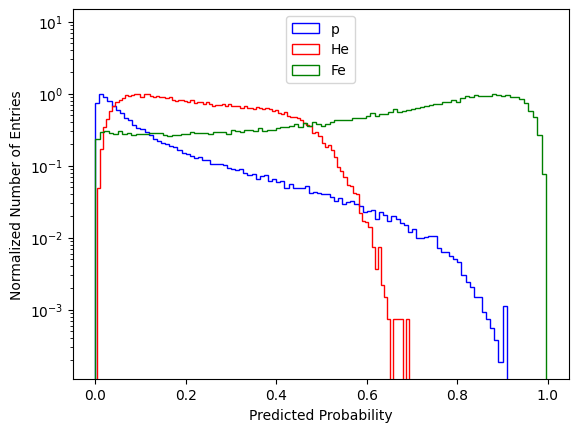

In [65]:
prob_cut = None

# Split predictions into three separate arrays for each class
p_predictions = predictions[:, 0]
he_predictions = predictions[:, 1]
fe_predictions = predictions[:, 2]

# Create histogram for each class
p_counts, p_bins, _ = plt.hist(p_predictions, bins=100, alpha=0, density=True)
he_counts, he_bins, _ = plt.hist(he_predictions, bins=100, alpha=0, density=True)
fe_counts, fe_bins, _ = plt.hist(fe_predictions, bins=100, alpha=0, density=True)

# Normalize the distributions
p_counts /= np.max(p_counts)
he_counts /= np.max(he_counts)
fe_counts /= np.max(fe_counts)

# Set the range of the y-axis to 0-1
#plt.ylim(0, 1.1)

# Plot the normalized histograms
plt.hist(p_bins[:-1], bins=p_bins, weights=p_counts, label='p', color='blue', histtype='step')
plt.hist(he_bins[:-1], bins=he_bins, weights=he_counts, label='He', color='red', histtype='step')
plt.hist(fe_bins[:-1], bins=fe_bins, weights=fe_counts, label='Fe', color='green', histtype='step')

# Set plot labels and legend
plt.xlabel('Predicted Probability')
plt.ylabel('Normalized Number of Entries')
plt.yscale('log')
if prob_cut is not None:
    plt.axvline(x=prob_cut, color='black', linestyle='--', label='Cut')

plt.legend(loc= 'upper center')

# Show the plot
plt.show()


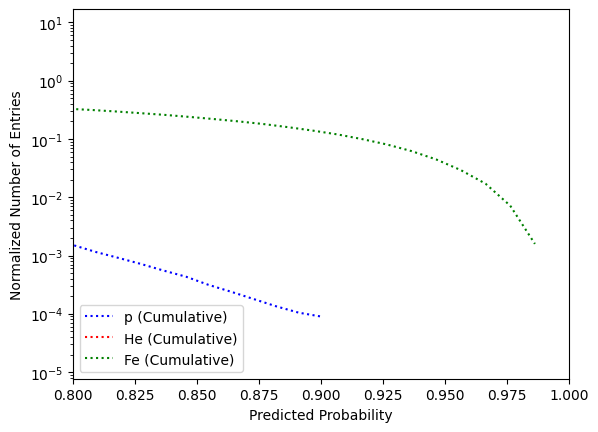

In [67]:
prob_cut = 0.8

# Split predictions into three separate arrays for each class
p_predictions = predictions[:, 0]
he_predictions = predictions[:, 1]
fe_predictions = predictions[:, 2]

# Create histogram for each class
p_counts, p_bins, _ = plt.hist(p_predictions, bins=100, alpha=0, density=True)
he_counts, he_bins, _ = plt.hist(he_predictions, bins=100, alpha=0, density=True)
fe_counts, fe_bins, _ = plt.hist(fe_predictions, bins=100, alpha=0, density=True)

# Normalize the distributions
p_counts /= np.max(p_counts)
he_counts /= np.max(he_counts)
fe_counts /= np.max(fe_counts)

# Set the range of the y-axis to 0-1
#plt.ylim(0, 1.1)

# Plot the normalized histograms
plt.hist(p_bins[:-1], bins=p_bins, weights=p_counts, alpha=0)
plt.hist(he_bins[:-1], bins=he_bins, weights=he_counts, alpha=0)
plt.hist(fe_bins[:-1], bins=fe_bins, weights=fe_counts, alpha=0)

# Calculate cumulative histograms
p_cumulative = np.cumsum(p_counts[::-1])[::-1]
he_cumulative = np.cumsum(he_counts[::-1])[::-1]
fe_cumulative = np.cumsum(fe_counts[::-1])[::-1]

# Normalize cumulative histograms
p_cumulative /= np.max(p_cumulative)
he_cumulative /= np.max(he_cumulative)
fe_cumulative /= np.max(fe_cumulative)

# Generate cumulative histogram plot
plt.plot(p_bins[:-1], p_cumulative, label='p (Cumulative)', color='blue', linestyle='dotted')
plt.plot(he_bins[:-1], he_cumulative, label='He (Cumulative)', color='red', linestyle='dotted')
plt.plot(fe_bins[:-1], fe_cumulative, label='Fe (Cumulative)', color='green', linestyle='dotted')

# Set plot labels and legend
plt.xlabel('Predicted Probability')
plt.ylabel('Normalized Number of Entries')
plt.legend(loc='lower left')
if prob_cut is not None:
    plt.xlim(prob_cut, 1)

# Set y-axis to log scale
plt.yscale('log')

# Show the plot
plt.show()


2092/2092 [==============================] - 9s 4ms/step


TypeError: unhashable type: 'slice'

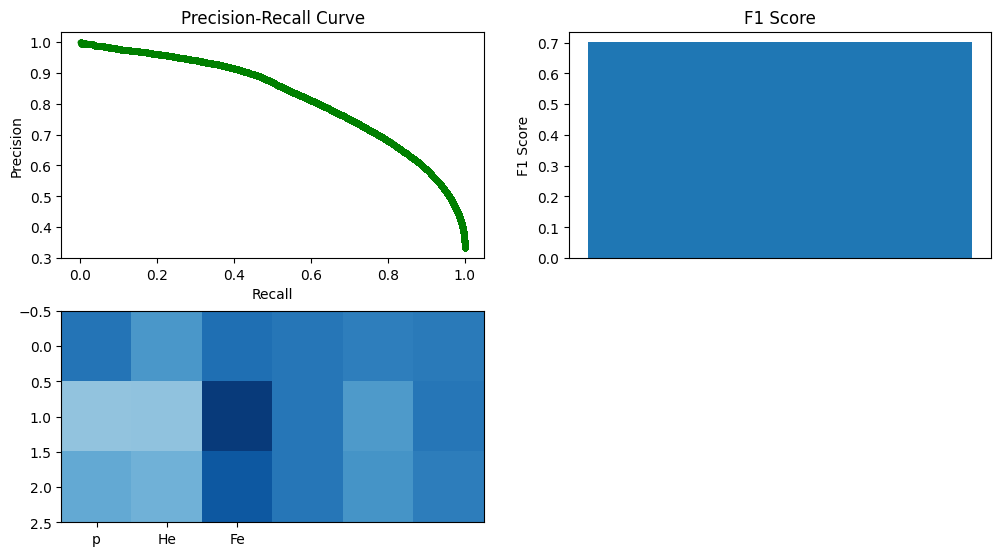

: 

In [17]:
utils.plot_evaluation_plots(ensemble_model, x_valid, y_valid)

# Convolutional Neural Network Model

In [ ]:
from ad.models.CNN import CNN

model = CNN (
            name='CNNetwork',
            num_classes=3,
            network=dict(
                        activation=tf.keras.activations.relu,
                        input_shape=(1, 1028, 1)
            )
        )
model.summary()


Model: "Classifier"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 in (InputLayer)             [(None, 1, 1028, 1)]      0         
                                                                 
 conv1 (Conv2D)              (None, 1, 1028, 32)       320       
                                                                 
 BN1 (BatchNormalization)    (None, 1, 1028, 32)       128       
                                                                 
 maxpool1 (MaxPooling2D)     (None, 1, 514, 32)        0         
                                                                 
 conv2 (Conv2D)              (None, 1, 514, 64)        18496     
                                                                 
 BN2 (BatchNormalization)    (None, 1, 514, 64)        256       
                                                                 
 maxpool2 (MaxPooling2D)     (None, 1, 257, 64)        0

In [ ]:
x_train = np.reshape(x_train, (x_train.shape[0], 1, x_train.shape[1], 1))
x_valid = np.reshape(x_valid, (x_valid.shape[0], 1, x_valid.shape[1], 1))
print(x_train.shape, x_valid.shape)

(250012, 1, 1028, 1) (62504, 1, 1028, 1)


In [ ]:
train = True

# Compile the model
model.network.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                      loss='sparse_categorical_crossentropy',
                      metrics=['accuracy'])
if train:
    # Train the model
    model.train(x_train, y_train, x_valid, y_valid, epochs=10, batch_size=256)
    # Save the model weights
    model.network.save_weights('./weights/CNN.h5')
else: 
    # Load the saved model weights
    model.network.load_weights('./weights/CNN.h5')

# Evaluate the model on the test set
test_loss, test_accuracy = model.network.evaluate(x_valid, y_valid)
print('Test loss:', test_loss)
print('Test accuracy:', test_accuracy)

Epoch 1/10


2023-06-14 12:23:19.870516: I tensorflow/core/common_runtime/executor.cc:1197] [/job:localhost/replica:0/task:0/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: logits and labels must have the same first dimension, got logits shape [256,3] and labels shape [768]
	 [[{{node sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/SparseSoftmaxCrossEntropyWithLogits}}]]


InvalidArgumentError: Graph execution error:

Detected at node 'sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/SparseSoftmaxCrossEntropyWithLogits' defined at (most recent call last):
    File "/nfs/pic.es/user/l/lvalente/miniconda3/lib/python3.10/runpy.py", line 196, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "/nfs/pic.es/user/l/lvalente/miniconda3/lib/python3.10/runpy.py", line 86, in _run_code
      exec(code, run_globals)
    File "/nfs/pic.es/user/l/lvalente/miniconda3/lib/python3.10/site-packages/ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "/nfs/pic.es/user/l/lvalente/miniconda3/lib/python3.10/site-packages/traitlets/config/application.py", line 992, in launch_instance
      app.start()
    File "/nfs/pic.es/user/l/lvalente/miniconda3/lib/python3.10/site-packages/ipykernel/kernelapp.py", line 711, in start
      self.io_loop.start()
    File "/nfs/pic.es/user/l/lvalente/miniconda3/lib/python3.10/site-packages/tornado/platform/asyncio.py", line 215, in start
      self.asyncio_loop.run_forever()
    File "/nfs/pic.es/user/l/lvalente/miniconda3/lib/python3.10/asyncio/base_events.py", line 603, in run_forever
      self._run_once()
    File "/nfs/pic.es/user/l/lvalente/miniconda3/lib/python3.10/asyncio/base_events.py", line 1909, in _run_once
      handle._run()
    File "/nfs/pic.es/user/l/lvalente/miniconda3/lib/python3.10/asyncio/events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "/nfs/pic.es/user/l/lvalente/miniconda3/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 510, in dispatch_queue
      await self.process_one()
    File "/nfs/pic.es/user/l/lvalente/miniconda3/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 499, in process_one
      await dispatch(*args)
    File "/nfs/pic.es/user/l/lvalente/miniconda3/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 406, in dispatch_shell
      await result
    File "/nfs/pic.es/user/l/lvalente/miniconda3/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 729, in execute_request
      reply_content = await reply_content
    File "/nfs/pic.es/user/l/lvalente/miniconda3/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 411, in do_execute
      res = shell.run_cell(
    File "/nfs/pic.es/user/l/lvalente/miniconda3/lib/python3.10/site-packages/ipykernel/zmqshell.py", line 531, in run_cell
      return super().run_cell(*args, **kwargs)
    File "/nfs/pic.es/user/l/lvalente/miniconda3/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3006, in run_cell
      result = self._run_cell(
    File "/nfs/pic.es/user/l/lvalente/miniconda3/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3061, in _run_cell
      result = runner(coro)
    File "/nfs/pic.es/user/l/lvalente/miniconda3/lib/python3.10/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "/nfs/pic.es/user/l/lvalente/miniconda3/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3266, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "/nfs/pic.es/user/l/lvalente/miniconda3/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3445, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "/nfs/pic.es/user/l/lvalente/miniconda3/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3505, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "/tmp/ipykernel_25226/2249083872.py", line 9, in <module>
      model.train(x_train, y_train, x_valid, y_valid, epochs=10, batch_size=256)
    File "/nfs/pic.es/user/l/lvalente/Exercises/MachineLearning/models/CNN.py", line 43, in train
      self.history = self.network.fit(X_train, y_train,
    File "/nfs/pic.es/user/l/lvalente/miniconda3/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/nfs/pic.es/user/l/lvalente/miniconda3/lib/python3.10/site-packages/keras/engine/training.py", line 1685, in fit
      tmp_logs = self.train_function(iterator)
    File "/nfs/pic.es/user/l/lvalente/miniconda3/lib/python3.10/site-packages/keras/engine/training.py", line 1284, in train_function
      return step_function(self, iterator)
    File "/nfs/pic.es/user/l/lvalente/miniconda3/lib/python3.10/site-packages/keras/engine/training.py", line 1268, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/nfs/pic.es/user/l/lvalente/miniconda3/lib/python3.10/site-packages/keras/engine/training.py", line 1249, in run_step
      outputs = model.train_step(data)
    File "/nfs/pic.es/user/l/lvalente/miniconda3/lib/python3.10/site-packages/keras/engine/training.py", line 1051, in train_step
      loss = self.compute_loss(x, y, y_pred, sample_weight)
    File "/nfs/pic.es/user/l/lvalente/miniconda3/lib/python3.10/site-packages/keras/engine/training.py", line 1109, in compute_loss
      return self.compiled_loss(
    File "/nfs/pic.es/user/l/lvalente/miniconda3/lib/python3.10/site-packages/keras/engine/compile_utils.py", line 265, in __call__
      loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    File "/nfs/pic.es/user/l/lvalente/miniconda3/lib/python3.10/site-packages/keras/losses.py", line 142, in __call__
      losses = call_fn(y_true, y_pred)
    File "/nfs/pic.es/user/l/lvalente/miniconda3/lib/python3.10/site-packages/keras/losses.py", line 268, in call
      return ag_fn(y_true, y_pred, **self._fn_kwargs)
    File "/nfs/pic.es/user/l/lvalente/miniconda3/lib/python3.10/site-packages/keras/losses.py", line 2078, in sparse_categorical_crossentropy
      return backend.sparse_categorical_crossentropy(
    File "/nfs/pic.es/user/l/lvalente/miniconda3/lib/python3.10/site-packages/keras/backend.py", line 5660, in sparse_categorical_crossentropy
      res = tf.nn.sparse_softmax_cross_entropy_with_logits(
Node: 'sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/SparseSoftmaxCrossEntropyWithLogits'
logits and labels must have the same first dimension, got logits shape [256,3] and labels shape [768]
	 [[{{node sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/SparseSoftmaxCrossEntropyWithLogits}}]] [Op:__inference_train_function_121379]

In [ ]:
print(model.predict(x_valid))
print(y_valid)

2674/2674 [==============================] - 111s 41ms/step


array([[0.03565626, 0.04326589, 0.92107785],
       [0.2987162 , 0.36233443, 0.3389494 ],
       [0.1584772 , 0.3691185 , 0.4724043 ],
       ...,
       [0.02087016, 0.05819074, 0.92093915],
       [0.12838735, 0.28142345, 0.5901892 ],
       [0.37405443, 0.30532902, 0.3206166 ]], dtype=float32)

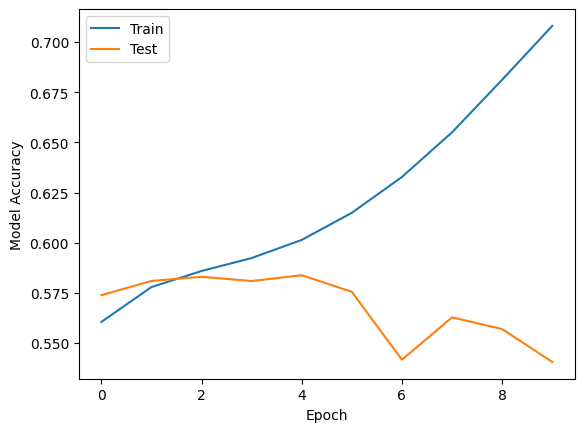

In [ ]:
plt.plot(model.history['accuracy'])
plt.plot(model.history['val_accuracy'])
plt.ylabel('Model Accuracy')
        
        
plt.xlabel('Epoch')        
plt.legend(['Train', 'Test'], loc='best')

plt.show()